# AIS Data Preprocessing for Voyage Delay Prediction
This notebook downloads, processes, and stores AIS data in a voyage-level format. Climate data is handled separately.

### AIS Download Data + Grouping by MMSI + Processing Data

In [1]:
import os
import zipfile
import pandas as pd
import shutil
from datetime import datetime, timedelta
from geopy.distance import geodesic
from tqdm import tqdm
import glob
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
import calendar
import numpy as np
from multiprocessing import cpu_count

# Configuration
DATA_DIR = "ais_data"
EXTRACT_DIR = "temp_data"
DAILY_DIR = "daily_summaries"
FINAL_OUTPUT = "ais_data_2022.csv"
CLEANED_OUTPUT = "ais_data_2022_cleaned.csv"

# Processing parameters
COLUMNS = ['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'VesselName', 'IMO']
CHUNK_SIZE = 100000
MAX_WORKERS = min(6, cpu_count())
DOWNLOAD_TIMEOUT = 120

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(EXTRACT_DIR, exist_ok=True)
os.makedirs(DAILY_DIR, exist_ok=True)

# Global session for connection reuse
session = requests.Session()
session.headers.update({'User-Agent': 'AIS-Data-Processor/2.0'})

print("🔧 Configuration completed!")
print(f"📊 Max workers: {MAX_WORKERS}")
print(f"💾 Storage directories created")

🔧 Configuration completed!
📊 Max workers: 6
💾 Storage directories created


In [2]:
def download_path(year, month, day):
    return f"https://coast.noaa.gov/htdata/CMSP/AISDataHandler/{year}/AIS_{year}_{month:02d}_{day:02d}.zip"

def download_file_aggressive(url, output_path):
    """Download"""
    try:
        with session.get(url, stream=True, timeout=DOWNLOAD_TIMEOUT) as response:
            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    shutil.copyfileobj(response.raw, f, length=16384)
                return True
            elif response.status_code == 404:
                return False  # Skip missing days
            return False
    except Exception as e:
        print(f"Download failed for {url}: {e}")
        return False

def extract_zip_ultra_fast(zip_path, extract_to):
    """Ultra-fast extraction"""
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            csv_files = [f for f in zip_ref.namelist() if f.endswith('.csv')]
            for file in csv_files:
                zip_ref.extract(file, extract_to)
        return True
    except Exception as e:
        print(f"Extraction failed: {e}")
        return False

def compute_distance_vectorized(coords):
    """Vectorized distance calculation using Haversine formula"""
    if len(coords) < 2:
        return 0.0
    
    coords_rad = np.radians(coords)
    dlat = np.diff(coords_rad[:, 0])
    dlon = np.diff(coords_rad[:, 1])
    
    lat1 = coords_rad[:-1, 0]
    lat2 = coords_rad[1:, 0]
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 6371  # Earth radius in km
    distances = r * c
    
    return np.sum(distances)

print("⚙️ Core functions loaded!")

⚙️ Core functions loaded!


In [3]:
def compute_summary_streamlined(df):
    """Streamlined summary computation - essential columns only"""
    if len(df) == 0:
        return pd.DataFrame()
    
    try:
        df = df.sort_values(['MMSI', 'BaseDateTime'])
        grouped = df.groupby('MMSI', observed=True)
        
        results = []
        
        for mmsi, group in grouped:
            if len(group) < 2:
                continue
            
            group = group.reset_index(drop=True)
            
            start_time = group['BaseDateTime'].iloc[0]
            end_time = group['BaseDateTime'].iloc[-1]
            duration_hours = (end_time - start_time).total_seconds() / 3600
            
            if duration_hours <= 0:
                continue
            
            coords = group[['LAT', 'LON']].values
            total_distance = compute_distance_vectorized(coords)
            avg_speed = total_distance / duration_hours
            
            # Get vessel details (handle missing columns gracefully)
            vessel_name = group['VesselName'].iloc[0] if 'VesselName' in group.columns else None
            imo = group['IMO'].iloc[0] if 'IMO' in group.columns else None
            avg_cog = group['COG'].mean() if group['COG'].notna().sum() > 0 else None
            
            results.append({
                'MMSI': str(mmsi),
                'VesselName': vessel_name,
                'IMO': imo,
                'StartTime': start_time,
                'EndTime': end_time,
                'StartLatitude': round(group['LAT'].iloc[0], 6),
                'StartLongitude': round(group['LON'].iloc[0], 6),
                'EndLatitude': round(group['LAT'].iloc[-1], 6),
                'EndLongitude': round(group['LON'].iloc[-1], 6),
                'DurationHours': round(duration_hours, 2),
                'TotalDistanceKM': round(total_distance, 2),
                'AverageSpeedKMH': round(avg_speed, 2),
                'AverageCOG': round(avg_cog, 2) if avg_cog is not None else None
            })
        
        return pd.DataFrame(results)
        
    except Exception as e:
        print(f"Error in compute_summary_streamlined: {e}")
        return pd.DataFrame()

def process_daily_data_streamlined(extracted_dir, year, month, day):
    """Streamlined daily processing"""
    daily_summary_path = os.path.join(DAILY_DIR, f"daily_{year}_{month:02d}_{day:02d}.csv")
    
    if os.path.exists(daily_summary_path):
        return daily_summary_path
    
    csv_files = [f for f in os.listdir(extracted_dir) if f.endswith(".csv")]
    
    if not csv_files:
        return None
    
    all_dfs = []
    for file in csv_files:
        csv_path = os.path.join(extracted_dir, file)
        try:
            # Check available columns first
            sample_df = pd.read_csv(csv_path, nrows=1)
            available_columns = [col for col in COLUMNS if col in sample_df.columns]
            
            df = pd.read_csv(csv_path, 
                           usecols=available_columns,
                           dtype={'MMSI': 'category', 'BaseDateTime': 'str', 
                                 'LAT': 'float32', 'LON': 'float32',
                                 'SOG': 'float32', 'COG': 'float32',
                                 'VesselName': 'str', 'IMO': 'str'},
                           low_memory=False,
                           engine='c')
            
            if len(df) > 0:
                all_dfs.append(df)
                
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            continue
    
    if not all_dfs:
        return None
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    del all_dfs
    
    # Basic cleaning
    mask = (combined_df['LAT'].notna() & 
            combined_df['LON'].notna() & 
            combined_df['BaseDateTime'].notna() &
            (combined_df['BaseDateTime'].str.len() > 0))
    
    combined_df = combined_df[mask]
    
    if len(combined_df) == 0:
        return None
    
    combined_df['BaseDateTime'] = pd.to_datetime(combined_df['BaseDateTime'], 
                                                errors='coerce', 
                                                format='mixed',
                                                cache=True)
    
    combined_df = combined_df.dropna(subset=['BaseDateTime'])
    
    if len(combined_df) == 0:
        return None
    
    daily_summary = compute_summary_streamlined(combined_df)
    
    if len(daily_summary) > 0:
        daily_summary.to_csv(daily_summary_path, index=False)
        print(f"✅ Daily {year}-{month:02d}-{day:02d}: {len(daily_summary)} vessels")
        return daily_summary_path
    
    return None

print("📊 Data processing functions loaded!")

📊 Data processing functions loaded!


In [4]:
def process_single_day_optimized(year, month, day):
    """Process single day with error handling"""
    try:
        url = download_path(year, month, day)
        zip_name = f"{year}_{month:02d}_{day:02d}.zip"
        zip_path = os.path.join(DATA_DIR, zip_name)
        extract_dir = os.path.join(EXTRACT_DIR, f"{year}_{month:02d}_{day:02d}")
        
        os.makedirs(extract_dir, exist_ok=True)
        
        if not download_file_aggressive(url, zip_path):
            return None
        
        if not extract_zip_ultra_fast(zip_path, extract_dir):
            return None
        
        daily_summary = process_daily_data_streamlined(extract_dir, year, month, day)
        
        # Cleanup
        try:
            os.remove(zip_path)
            shutil.rmtree(extract_dir)
        except:
            pass
        
        return daily_summary
        
    except Exception as e:
        print(f"Day {day:02d} failed: {e}")
        return None

def combine_monthly_summaries_streamlined(year, month):
    """Combine daily files into monthly summary"""
    pattern = os.path.join(DAILY_DIR, f"daily_{year}_{month:02d}_*.csv")
    daily_files = glob.glob(pattern)
    
    if not daily_files:
        print(f"❌ No daily files for {year}-{month:02d}")
        return
    
    dfs = []
    for file in daily_files:
        try:
            df = pd.read_csv(file, 
                           parse_dates=['StartTime', 'EndTime'],
                           dtype={'MMSI': 'str', 'VesselName': 'str', 'IMO': 'str'})
            dfs.append(df)
        except:
            continue
    
    if not dfs:
        return
    
    monthly_df = pd.concat(dfs, ignore_index=True)
    del dfs
    
    # Aggregate by vessel
    agg_dict = {
        'StartTime': 'min',
        'EndTime': 'max',
        'TotalDistanceKM': 'sum',
        'AverageCOG': 'mean',
        'VesselName': 'first',
        'IMO': 'first',
        'StartLatitude': 'first',
        'StartLongitude': 'first',
        'EndLatitude': 'last',
        'EndLongitude': 'last'
    }
    
    final_monthly = monthly_df.groupby('MMSI').agg(agg_dict).reset_index()
    
    # Recalculate duration and speed
    final_monthly['DurationHours'] = (final_monthly['EndTime'] - final_monthly['StartTime']).dt.total_seconds() / 3600
    final_monthly['AverageSpeedKMH'] = final_monthly['TotalDistanceKM'] / final_monthly['DurationHours']
    
    # Round values
    for col in ['DurationHours', 'TotalDistanceKM', 'AverageSpeedKMH', 'AverageCOG']:
        if col in final_monthly.columns:
            final_monthly[col] = final_monthly[col].round(2)
    
    # Append to final output
    header_needed = not os.path.exists(FINAL_OUTPUT)
    final_monthly.to_csv(FINAL_OUTPUT, mode='a', header=header_needed, index=False)
    
    print(f"✅ {year}-{month:02d}: {len(final_monthly)} vessels → {FINAL_OUTPUT}")
    
    # Cleanup daily files
    for file in daily_files:
        try:
            os.remove(file)
        except:
            pass

def run_pipeline_month(year, month):
    """Process single month"""
    print(f"\n🚀 Processing {year}-{month:02d}")
    start_time = datetime.now()
    
    days_in_month = calendar.monthrange(year, month)[1]
    
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {
            executor.submit(process_single_day_optimized, year, month, day): day 
            for day in range(1, days_in_month + 1)
        }
        
        successful = 0
        for future in tqdm(as_completed(futures), total=days_in_month, 
                          desc=f"{year}-{month:02d}"):
            try:
                result = future.result()
                if result:
                    successful += 1
            except:
                pass
    
    print(f"📊 Processed {successful}/{days_in_month} days")
    
    combine_monthly_summaries_streamlined(year, month)
    
    duration = (datetime.now() - start_time).total_seconds() / 60
    print(f"⏱️  Month completed in {duration:.1f} minutes")

print("🔄 Pipeline orchestration functions loaded!")

🔄 Pipeline orchestration functions loaded!


In [5]:
def preprocess_data():
    """
    DATA PREPROCESSING
    
    Key Steps:
    1. Load data with optimized dtypes
    2. Validate MMSI (Maritime Mobile Service Identity)
    3. Validate coordinates (latitude/longitude ranges)
    4. Validate speeds and distances
    5. Validate time sequences
    6. Remove outliers
    7. Remove duplicates
    8. Save cleaned dataset
    """
    
    print("\n" + "="*70)
    print("🔧 STARTING DATA PREPROCESSING")
    print("="*70)
    
    # Step 1: Load data with optimized dtypes
    print("📂 Step 1: Loading raw data...")
    
    try:
        df = pd.read_csv(FINAL_OUTPUT, 
                        dtype={
                            'MMSI': 'str',
                            'VesselName': 'str',
                            'IMO': 'str',
                            'TotalDistanceKM': 'float32',
                            'DurationHours': 'float32',
                            'AverageSpeedKMH': 'float32',
                            'AverageCOG': 'float32',
                            'StartLatitude': 'float32',
                            'StartLongitude': 'float32',
                            'EndLatitude': 'float32',
                            'EndLongitude': 'float32'
                        },
                        parse_dates=['StartTime', 'EndTime'])
        
        print(f"   ✅ Loaded {len(df):,} voyages, {df.shape[1]} columns")
        print(f"   💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
    except FileNotFoundError:
        print(f"   ❌ File {FINAL_OUTPUT} not found! Run data collection first.")
        return None
    except Exception as e:
        print(f"   ❌ Error loading data: {e}")
        return None
    
    original_count = len(df)
    
    # Step 2: Missing value analysis
    print("\n🔍 Step 2: Analyzing missing values...")
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df) * 100).round(2)
    
    for col in missing_counts.index:
        if missing_counts[col] > 0:
            print(f"   ⚠️  {col}: {missing_counts[col]:,} missing ({missing_percent[col]}%)")
        else:
            print(f"   ✅ {col}: Complete")
    
    # Step 3: Basic validation (ranges and format)
    print("\n🧹 Step 3: Basic data validation...")
    
    print("   🔹 MMSI Validation:")
    print("      - Must be 7-15 digits (IMO standard)")
    print("      - Cannot be '0' (invalid identifier)")
    
    mmsi_valid = (
        df['MMSI'].notna() &
        (df['MMSI'].str.len().between(7, 15)) &
        (df['MMSI'] != '0') &
        (df['MMSI'].str.match(r'^\d+$', na=False))
    )
    print(f"      ✅ MMSI valid: {mmsi_valid.sum():,}/{len(df):,}")
    
    print("   🔹 Coordinate Validation:")
    print("      - Latitude: -90° to +90° (Geographic bounds)")
    print("      - Longitude: -180° to +180° (Geographic bounds)")
    
    coord_valid = (
        df['StartLatitude'].between(-90, 90) &
        df['StartLongitude'].between(-180, 180) &
        df['EndLatitude'].between(-90, 90) &
        df['EndLongitude'].between(-180, 180)
    )
    print(f"      ✅ Coordinates valid: {coord_valid.sum():,}/{len(df):,}")
    
    print("   🔹 Time Sequence Validation:")
    print("      - StartTime must be <= EndTime")
    print("      - Both times must be present")
    
    time_valid = (
        df['StartTime'].notna() &
        df['EndTime'].notna() &
        (df['StartTime'] <= df['EndTime'])
    )
    print(f"      ✅ Time sequence valid: {time_valid.sum():,}/{len(df):,}")
    
    print("   🔹 Positive Values Validation:")
    print("      - Distance, Duration, Speed must be > 0")
    
    positive_valid = (
        (df['TotalDistanceKM'] > 0) &
        (df['DurationHours'] > 0) &
        (df['AverageSpeedKMH'] > 0)
    )
    print(f"      ✅ Positive values valid: {positive_valid.sum():,}/{len(df):,}")
    
    # Combine basic validation rules
    basic_valid = mmsi_valid & coord_valid & time_valid & positive_valid
    df_basic = df[basic_valid].copy()
    removed_basic = original_count - len(df_basic)
    
    print(f"\n   📊 Basic Validation Summary:")
    print(f"      Removed: {removed_basic:,} rows ({(removed_basic/original_count*100):.1f}%)")
    print(f"      Remaining: {len(df_basic):,} voyages")
    
    # Step 4: CRITICAL - Mathematical Relationship Validation
    print("\n🔧 Step 4: Mathematical Relationship Validation...")
    print("   🎯 MOST IMPORTANT: Validating Speed = Distance/Time relationship")
    print("   📐 Formula: AverageSpeedKMH should equal TotalDistanceKM/DurationHours")
    print("   🎛️  Tolerance: ±5% difference allowed (due to rounding)")
    
    # Calculate expected speed from distance and time
    expected_speed = df_basic['TotalDistanceKM'] / df_basic['DurationHours']
    actual_speed = df_basic['AverageSpeedKMH']
    
    # Calculate percentage difference
    speed_diff_pct = np.abs(actual_speed - expected_speed) / (expected_speed + 0.001) * 100
    
    # Allow 5% tolerance for rounding errors
    speed_consistent = speed_diff_pct <= 5.0
    
    inconsistent_count = (~speed_consistent).sum()
    print(f"   ⚠️  Found {inconsistent_count:,} voyages with speed inconsistency > 5%")
    print(f"   🗑️  These will be DROPPED (not corrected) to maintain data integrity")
    
    # Show some examples of inconsistent data
    if inconsistent_count > 0:
        print(f"\n   📋 Examples of inconsistent data (first 3):")
        inconsistent_sample = df_basic[~speed_consistent].head(3)
        for idx, row in inconsistent_sample.iterrows():
            calc_speed = row['TotalDistanceKM'] / row['DurationHours']
            actual = row['AverageSpeedKMH']
            diff = abs(calc_speed - actual) / calc_speed * 100
            print(f"      MMSI {row['MMSI']}: Expected {calc_speed:.4f} km/h, Got {actual:.4f} km/h (Diff: {diff:.1f}%)")
    
    df_consistent = df_basic[speed_consistent].copy()
    
    # Step 5: Reasonable range validation (AFTER relationship check)
    print("\n📏 Step 5: Reasonable range validation...")
    print("   📊 These ranges are for VOYAGE-LEVEL data (not individual AIS positions)")
    
    print("   🔹 Distance Range: 0.1 km to 50,000 km")
    print("      Logic: Min voyage vs max around-world distance")
    
    print("   🔹 Duration Range: 0.1 hours to 8,760 hours")
    print("      Logic: 6 minutes minimum to 1 year maximum")
    
    print("   🔹 Speed Range: 0.1 km/h to 100 km/h")
    print("      Logic: Very slow vessel to very fast vessel")
    
    reasonable_ranges = (
        # Distance: 0.1 km to 50,000 km
        (df_consistent['TotalDistanceKM'] >= 0.1) &
        (df_consistent['TotalDistanceKM'] <= 50000) &
        
        # Duration: 0.1 hours to 8,760 hours (6 minutes to 1 year)
        (df_consistent['DurationHours'] >= 0.1) &
        (df_consistent['DurationHours'] <= 8760) &
        
        # Speed: 0.1 km/h to 100 km/h
        (df_consistent['AverageSpeedKMH'] >= 0.1) &
        (df_consistent['AverageSpeedKMH'] <= 100) &
        
        # COG: 0° to 360° (or allow NaN)
        (df_consistent['AverageCOG'].between(0, 360) | df_consistent['AverageCOG'].isna())
    )
    
    df_reasonable = df_consistent[reasonable_ranges].copy()
    removed_unreasonable = len(df_consistent) - len(df_reasonable)
    print(f"   ❌ Removed {removed_unreasonable:,} voyages outside reasonable ranges")
    
    # Step 6: Statistical outlier removal
    print("\n📊 Step 6: Statistical outlier removal...")
    print("   📈 Using 1st and 99th percentile method (robust against extreme outliers)")
    
    outlier_cols = ['TotalDistanceKM', 'DurationHours', 'AverageSpeedKMH']
    outlier_mask = pd.Series(True, index=df_reasonable.index)
    
    for col in outlier_cols:
        if col in df_reasonable.columns:
            lower = df_reasonable[col].quantile(0.01)
            upper = df_reasonable[col].quantile(0.99)
            col_mask = df_reasonable[col].between(lower, upper)
            outliers = (~col_mask).sum()
            outlier_mask &= col_mask
            print(f"   📊 {col}: [{lower:.2f}, {upper:.2f}], removed {outliers:,} outliers")
    
    df_clean = df_reasonable[outlier_mask].copy()
    removed_outliers = len(df_reasonable) - len(df_clean)

    # Step 7: Approach to duplicates
    print("\n🔍 Step 7: Handling voyage duplicates...")
    print("   ✅ LOGIC: Same MMSI can have multiple voyages!")
    print("   🔹 Different voyages = Different time periods")
    print("   🗑️  Only remove EXACT duplicates (same MMSI + same StartTime)")
    
    # Check for exact duplicate voyages
    pre_duplicate_count = len(df_clean)
    duplicate_voyages = df_clean.duplicated(subset=['MMSI', 'StartTime'], keep='first')
    exact_duplicates = duplicate_voyages.sum()
    
    if exact_duplicates > 0:
        print(f"   ❌ Found {exact_duplicates} exact duplicate voyages")
        df_clean = df_clean[~duplicate_voyages]
    else:
        print(f"   ✅ No exact duplicate voyages found")
    
    # Analyze voyage distribution per vessel
    voyage_counts = df_clean.groupby('MMSI').size()
    vessels_with_multiple = (voyage_counts > 1).sum()
    max_voyages = voyage_counts.max()
    avg_voyages = voyage_counts.mean()
    
    print(f"\n   📊 Voyage Distribution Analysis:")
    print(f"      Total unique vessels: {len(voyage_counts):,}")
    print(f"      Vessels with multiple voyages: {vessels_with_multiple:,}")
    print(f"      Average voyages per vessel: {avg_voyages:.2f}")
    print(f"      Maximum voyages per vessel: {max_voyages}")
    
    # Memory optimization
    # Convert to optimal dtypes
    df_clean = df_clean.astype({
        'TotalDistanceKM': 'float32',
        'DurationHours': 'float32',
        'AverageSpeedKMH': 'float32',
        'AverageCOG': 'float32',
        'StartLatitude': 'float32',
        'StartLongitude': 'float32',
        'EndLatitude': 'float32',
        'EndLongitude': 'float32'
    })

    # Step 8: Save corrected dataset
    print("\n💾 Step 8: Saving corrected dataset...")
    
    try:
        df_clean.to_csv(CLEANED_OUTPUT, index=False)
        file_size = os.path.getsize(CLEANED_OUTPUT) / 1024**2
        print(f"   ✅ Saved to: {CLEANED_OUTPUT}")
        print(f"   📁 File size: {file_size:.1f}MB")
    except Exception as e:
        print(f"   ❌ Error saving: {e}")
        return None

    # Step 9: Final summary and validation test
    print("\n" + "="*70)
    print("📊 PREPROCESSING SUMMARY")
    print("="*70)
    print(f"Original voyages:              {original_count:,}")
    print(f"After basic validation:        {len(df_basic):,}")
    print(f"After relationship check:      {len(df_consistent):,}")
    print(f"After range validation:        {len(df_reasonable):,}")
    print(f"After outlier removal:         {len(df_clean):,}")
    print(f"Final clean voyages:           {len(df_clean):,}")
    print(f"Total removed:                 {original_count - len(df_clean):,}")
    print(f"Data retention rate:           {(len(df_clean)/original_count*100):.1f}%")
        
    print(f"\n📋 FINAL COLUMN LIST ({df_clean.shape[1]} columns):")
    for i, col in enumerate(df_clean.columns, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\n📈 FINAL DATA STATISTICS:")
    print(df_clean[['TotalDistanceKM', 'DurationHours', 'AverageSpeedKMH']].describe())
    
    print("\n✅ PREPROCESSING COMPLETED SUCCESSFULLY!")
    
    return df_clean

print("🔧 Data preprocessing functions loaded!")

🔧 Data preprocessing functions loaded!


In [ ]:
def run_complete_pipeline():
    """
    COMPLETE PIPELINE
    
    This function runs the entire AIS data processing pipeline:
    1. Data Collection (Download, Extract, Process)
    2. Data Preprocessing (Clean, Validate, Summarize)
    3. Final Output Generation
    """
    
    print("🚀" * 20)
    print("STARTING COMPLETE AIS DATA PROCESSING PIPELINE")
    print("🚀" * 20)
    
    pipeline_start = datetime.now()
    
    # PHASE 1: DATA COLLECTION
    print("\n" + "="*60)
    print("PHASE 1: DATA COLLECTION")
    print("="*60)
    
    print(f"📊 Chunk size: {CHUNK_SIZE:,}")
    print(f"🔄 Max workers: {MAX_WORKERS}")
    print(f"💾 Daily summaries: {DAILY_DIR}")
    print(f"📁 Raw output: {FINAL_OUTPUT}")
    
    # Configure date range - MODIFY THIS TO CHANGE DATA RANGE
    START_YEAR = 2021
    END_YEAR = 2022
    START_MONTH = 11
    END_MONTH = 13
    
    print(f"\n📅 Processing date range:")
    print(f"   Years: {START_YEAR} to {END_YEAR-1}")
    print(f"   Months: {START_MONTH} to {END_MONTH-1}")
    
    # Data collection loop
    total_months = 0
    successful_months = 0
    
    for year in range(START_YEAR, END_YEAR):
        for month in range(START_MONTH, END_MONTH):
            try:
                run_pipeline_month(year, month)
                successful_months += 1
            except Exception as e:
                print(f"❌ Failed to process {year}-{month:02d}: {e}")
            total_months += 1
    
    print(f"\n📊 Data Collection Summary:")
    print(f"   Total months processed: {successful_months}/{total_months}")
    print(f"   Success rate: {(successful_months/total_months*100):.1f}%")
    
    # PHASE 2: DATA PREPROCESSING
    print("\n" + "="*60)
    print("PHASE 2: DATA PREPROCESSING")
    print("="*60)
    
    # Check if raw data exists
    if not os.path.exists(FINAL_OUTPUT):
        print(f"❌ Raw data file {FINAL_OUTPUT} not found!")
        print("   Please run data collection first.")
        return None
    
    # Run comprehensive preprocessing
    cleaned_df = preprocess_data()
    
    if cleaned_df is None:
        print("❌ Preprocessing failed!")
        return None
    
    # PHASE 3: PIPELINE COMPLETION
    print("\n" + "="*60)
    print("PHASE 3: PIPELINE COMPLETION")
    print("="*60)
    
    pipeline_end = datetime.now()
    total_duration = (pipeline_end - pipeline_start).total_seconds() / 60
    
    print(f"⏱️  Total pipeline duration: {total_duration:.1f} minutes")
    print(f"📁 Raw data file: {FINAL_OUTPUT}")
    print(f"🧹 Cleaned data file: {CLEANED_OUTPUT}")
    
    # Final file statistics
    if os.path.exists(FINAL_OUTPUT):
        raw_size = os.path.getsize(FINAL_OUTPUT) / 1024**2
        print(f"📊 Raw file size: {raw_size:.1f}MB")
    
    if os.path.exists(CLEANED_OUTPUT):
        clean_size = os.path.getsize(CLEANED_OUTPUT) / 1024**2
        print(f"✨ Cleaned file size: {clean_size:.1f}MB")
    
    print("\n")
    print("🎉" * 20)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("🎉" * 20)
    
    return cleaned_df

result = run_complete_pipeline()

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
STARTING COMPLETE AIS DATA PROCESSING PIPELINE
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

PHASE 1: DATA COLLECTION
📊 Chunk size: 100,000
🔄 Max workers: 6
💾 Daily summaries: daily_summaries
📁 Raw output: ais_data_2024.csv

📅 Processing date range:
   Years: 2024 to 2024
   Months: 11 to 12

🚀 Processing 2024-11


2024-11:   0%|          | 0/30 [00:00<?, ?it/s]

2024-11:   3%|▎         | 1/30 [05:09<2:29:46, 309.87s/it]

✅ Daily 2024-11-02: 18162 vessels


2024-11:   7%|▋         | 2/30 [05:49<1:10:29, 151.06s/it]

✅ Daily 2024-11-01: 18928 vessels


2024-11:  10%|█         | 3/30 [05:54<37:56, 84.31s/it]   

✅ Daily 2024-11-03: 17811 vessels


2024-11:  13%|█▎        | 4/30 [05:57<22:33, 52.05s/it]

✅ Daily 2024-11-04: 18779 vessels


2024-11:  17%|█▋        | 5/30 [06:00<14:25, 34.61s/it]

✅ Daily 2024-11-06: 18671 vessels


2024-11:  20%|██        | 6/30 [06:02<09:19, 23.30s/it]

✅ Daily 2024-11-05: 18300 vessels
✅ Daily 2024-11-07: 19125 vessels


2024-11:  23%|██▎       | 7/30 [07:52<19:52, 51.85s/it]

✅ Daily 2024-11-11: 18198 vessels


2024-11:  27%|██▋       | 8/30 [10:07<28:43, 78.33s/it]

✅ Daily 2024-11-08: 19264 vessels


2024-11:  33%|███▎      | 10/30 [10:58<16:56, 50.82s/it]

✅ Daily 2024-11-12: 18662 vessels


2024-11:  37%|███▋      | 11/30 [11:07<12:01, 37.97s/it]

✅ Daily 2024-11-10: 17800 vessels


2024-11:  40%|████      | 12/30 [11:09<08:04, 26.94s/it]

✅ Daily 2024-11-09: 18173 vessels


2024-11:  43%|████▎     | 13/30 [11:25<06:42, 23.66s/it]

✅ Daily 2024-11-13: 18451 vessels


2024-11:  47%|████▋     | 14/30 [13:12<12:59, 48.71s/it]

✅ Daily 2024-11-14: 18723 vessels


2024-11:  50%|█████     | 15/30 [14:00<12:10, 48.68s/it]

✅ Daily 2024-11-17: 17822 vessels


2024-11:  53%|█████▎    | 16/30 [14:59<12:04, 51.77s/it]

✅ Daily 2024-11-15: 18709 vessels


2024-11:  57%|█████▋    | 17/30 [15:17<08:59, 41.49s/it]

✅ Daily 2024-11-16: 18461 vessels


2024-11:  60%|██████    | 18/30 [15:36<06:56, 34.75s/it]

✅ Daily 2024-11-18: 18920 vessels


2024-11:  63%|██████▎   | 19/30 [15:58<05:40, 30.92s/it]

✅ Daily 2024-11-19: 18775 vessels
✅ Daily 2024-11-20: 18640 vessels


2024-11:  67%|██████▋   | 20/30 [16:25<04:58, 29.89s/it]

✅ Daily 2024-11-21: 17904 vessels


2024-11:  73%|███████▎  | 22/30 [17:36<04:36, 34.59s/it]

✅ Daily 2024-11-22: 17872 vessels


2024-11:  77%|███████▋  | 23/30 [19:09<06:03, 51.94s/it]

✅ Daily 2024-11-24: 17998 vessels


2024-11:  80%|████████  | 24/30 [19:10<03:39, 36.65s/it]

✅ Daily 2024-11-23: 17920 vessels


2024-11:  83%|████████▎ | 25/30 [19:40<02:53, 34.74s/it]

✅ Daily 2024-11-25: 18516 vessels


2024-11:  87%|████████▋ | 26/30 [20:01<02:02, 30.63s/it]

✅ Daily 2024-11-26: 18341 vessels
✅ Daily 2024-11-27: 18450 vessels


2024-11:  90%|█████████ | 27/30 [20:22<01:23, 27.74s/it]

✅ Daily 2024-11-28: 17042 vessels


2024-11:  93%|█████████▎| 28/30 [20:32<00:44, 22.39s/it]

✅ Daily 2024-11-30: 17291 vessels


2024-11: 100%|██████████| 30/30 [21:29<00:00, 43.00s/it]

✅ Daily 2024-11-29: 17594 vessels
📊 Processed 30/30 days


✅ 2024-11: 40126 vessels → ais_data_2024.csv
⏱️  Month completed in 21.6 minutes

🚀 Processing 2024-12


2024-12:   3%|▎         | 1/31 [04:02<2:01:23, 242.77s/it]

✅ Daily 2024-12-01: 16710 vessels


2024-12:   6%|▋         | 2/31 [04:46<1:00:42, 125.60s/it]

✅ Daily 2024-12-05: 17766 vessels


2024-12:  10%|▉         | 3/31 [04:52<33:06, 70.96s/it]   

✅ Daily 2024-12-04: 17891 vessels


2024-12:  13%|█▎        | 4/31 [04:54<19:47, 43.99s/it]

✅ Daily 2024-12-03: 17891 vessels


2024-12:  16%|█▌        | 5/31 [05:01<13:16, 30.64s/it]

✅ Daily 2024-12-06: 18314 vessels


2024-12:  19%|█▉        | 6/31 [05:03<08:36, 20.65s/it]

✅ Daily 2024-12-02: 18012 vessels


2024-12:  23%|██▎       | 7/31 [06:04<13:31, 33.81s/it]

✅ Daily 2024-12-07: 17132 vessels


2024-12:  26%|██▌       | 8/31 [09:21<32:57, 85.97s/it]

✅ Daily 2024-12-11: 16468 vessels
✅ Daily 2024-12-12: 16592 vessels


2024-12:  29%|██▉       | 9/31 [09:23<21:54, 59.74s/it]

✅ Daily 2024-12-09: 18255 vessels


2024-12:  32%|███▏      | 10/31 [09:29<15:07, 43.19s/it]

✅ Daily 2024-12-08: 16834 vessels


2024-12:  39%|███▊      | 12/31 [09:47<08:13, 25.99s/it]

✅ Daily 2024-12-10: 17982 vessels


2024-12:  42%|████▏     | 13/31 [09:48<05:32, 18.44s/it]

✅ Daily 2024-12-13: 17423 vessels


2024-12:  45%|████▌     | 14/31 [13:27<22:21, 78.93s/it]

✅ Daily 2024-12-16: 17507 vessels


2024-12:  48%|████▊     | 15/31 [13:45<16:12, 60.79s/it]

✅ Daily 2024-12-17: 17391 vessels
✅ Daily 2024-12-18: 16845 vessels


2024-12:  52%|█████▏    | 16/31 [14:04<12:03, 48.21s/it]

✅ Daily 2024-12-19: 16977 vessels


2024-12:  58%|█████▊    | 18/31 [14:17<05:45, 26.57s/it]

✅ Daily 2024-12-14: 16825 vessels


2024-12:  61%|██████▏   | 19/31 [14:18<03:47, 18.96s/it]

✅ Daily 2024-12-15: 16618 vessels


2024-12:  65%|██████▍   | 20/31 [16:15<08:52, 48.36s/it]

✅ Daily 2024-12-24: 15809 vessels


2024-12:  68%|██████▊   | 21/31 [17:37<09:44, 58.45s/it]

✅ Daily 2024-12-25: 14165 vessels


2024-12:  71%|███████   | 22/31 [18:08<07:31, 50.12s/it]

✅ Daily 2024-12-23: 16269 vessels


2024-12:  74%|███████▍  | 23/31 [18:14<04:55, 36.92s/it]

✅ Daily 2024-12-22: 16023 vessels


2024-12:  77%|███████▋  | 24/31 [18:24<03:21, 28.79s/it]

✅ Daily 2024-12-20: 17562 vessels


2024-12:  81%|████████  | 25/31 [18:33<02:17, 22.92s/it]

✅ Daily 2024-12-21: 16819 vessels


2024-12:  84%|████████▍ | 26/31 [18:48<01:42, 20.48s/it]

✅ Daily 2024-12-26: 15324 vessels
✅ Daily 2024-12-27: 15907 vessels


2024-12:  90%|█████████ | 28/31 [20:59<02:10, 43.44s/it]

✅ Daily 2024-12-29: 15531 vessels


2024-12:  94%|█████████▎| 29/31 [21:20<01:13, 36.72s/it]

✅ Daily 2024-12-28: 15707 vessels


2024-12:  97%|█████████▋| 30/31 [21:35<00:30, 30.10s/it]

✅ Daily 2024-12-30: 16893 vessels


2024-12: 100%|██████████| 31/31 [21:41<00:00, 41.97s/it]

✅ Daily 2024-12-31: 16963 vessels
📊 Processed 31/31 days


✅ 2024-12: 36389 vessels → ais_data_2024.csv
⏱️  Month completed in 21.8 minutes

📊 Data Collection Summary:
   Total months processed: 2/2
   Success rate: 100.0%

PHASE 2: DATA PREPROCESSING

🔧 STARTING DATA PREPROCESSING
📂 Step 1: Loading raw data...
   ✅ Loaded 517,619 voyages, 13 columns
   💾 Memory usage: 106.5 MB

🔍 Step 2: Analyzing missing values...
   ✅ MMSI: Complete
   ✅ StartTime: Complete
   ✅ EndTime: Complete
   ✅ TotalDistanceKM: Complete
   ✅ AverageCOG: Complete
   ⚠️  VesselName: 6,468 missing (1.25%)
   ⚠️  IMO: 151,450 missing (29.26%)
   ✅ StartLatitude: Complete
   ✅ StartLongitude: Complete
   ✅ EndLatitude: Complete
   ✅ EndLongitude: Complete
   ✅ DurationHours: Complete
   ✅ AverageSpeedKMH: Complete

🧹 Step 3: Basic data validation...
   🔹 MMSI Validation:
      - Must be 7-15 digits (IMO standard)
      - Cannot be '0' (invalid identifier)
      ✅ MMSI valid: 517,345/517,619
   🔹 Coordinate Validation:
      - Latitude: -90° to +90° (Geographic bounds)
   

In [6]:
def run_preprocessing_only():
    """
    PREPROCESSING PIPELINE (PHASE 2 & 3)
    
    This function runs only the preprocessing steps:
    1. Data Preprocessing (Clean, Validate, Summarize)
    2. Final Output Generation
    
    Assumes raw data file already exists.
    """
    
    print("🚀" * 20)
    print("STARTING AIS DATA PREPROCESSING")
    print("🚀" * 20)
    
    pipeline_start = datetime.now()
    
    # PHASE 2: DATA PREPROCESSING
    print("\n" + "="*60)
    print("PHASE 2: DATA PREPROCESSING")
    print("="*60)
    
    # Check if raw data exists
    if not os.path.exists(FINAL_OUTPUT):
        print(f"❌ Raw data file {FINAL_OUTPUT} not found!")
        print("   Please run data collection first.")
        return None
    
    # Run comprehensive preprocessing
    cleaned_df = preprocess_data()
    
    if cleaned_df is None:
        print("❌ Preprocessing failed!")
        return None
    
    # PHASE 3: PIPELINE COMPLETION
    print("\n" + "="*60)
    print("PHASE 3: PIPELINE COMPLETION")
    print("="*60)
    
    pipeline_end = datetime.now()
    total_duration = (pipeline_end - pipeline_start).total_seconds() / 60
    
    print(f"⏱️  Total pipeline duration: {total_duration:.1f} minutes")
    print(f"📁 Raw data file: {FINAL_OUTPUT}")
    print(f"🧹 Cleaned data file: {CLEANED_OUTPUT}")
    
    # Final file statistics
    if os.path.exists(FINAL_OUTPUT):
        raw_size = os.path.getsize(FINAL_OUTPUT) / 1024**2
        print(f"📊 Raw file size: {raw_size:.1f}MB")
    
    if os.path.exists(CLEANED_OUTPUT):
        clean_size = os.path.getsize(CLEANED_OUTPUT) / 1024**2
        print(f"✨ Cleaned file size: {clean_size:.1f}MB")
    
    print("\n")
    print("🎉" * 20)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("🎉" * 20)
    
    return cleaned_df

# Run the preprocessing
result = run_preprocessing_only()

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
STARTING AIS DATA PREPROCESSING
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

PHASE 2: DATA PREPROCESSING

🔧 STARTING DATA PREPROCESSING
📂 Step 1: Loading raw data...
   ✅ Loaded 460,900 voyages, 13 columns
   💾 Memory usage: 94.0 MB

🔍 Step 2: Analyzing missing values...
   ✅ MMSI: Complete
   ✅ StartTime: Complete
   ✅ EndTime: Complete
   ✅ TotalDistanceKM: Complete
   ✅ AverageCOG: Complete
   ⚠️  VesselName: 5,834 missing (1.27%)
   ⚠️  IMO: 168,434 missing (36.54%)
   ✅ StartLatitude: Complete
   ✅ StartLongitude: Complete
   ✅ EndLatitude: Complete
   ✅ EndLongitude: Complete
   ✅ DurationHours: Complete
   ✅ AverageSpeedKMH: Complete

🧹 Step 3: Basic data validation...
   🔹 MMSI Validation:
      - Must be 7-15 digits (IMO standard)
      - Cannot be '0' (invalid identifier)
      ✅ MMSI valid: 460,370/460,900
   🔹 Coordinate Validation:
      - Latitude: -90° to +90° (Geographic bounds)
      - Longitude: -180° to +180° (Geographic bounds)
      ✅ Coordinates valid: 460,900/460,9

### Graphical Analysis

In [1]:
# Comprehensive EDA for AIS Cleaned Data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define file path
CLEANED_OUTPUT = 'final_output_cleaned.csv'

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
EXPLORATORY DATA ANALYSIS - CLEANED AIS DATA
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
✅ Loaded cleaned data: 296,850 voyages
📊 Dataset shape: (296850, 13)
💾 Memory usage: 59.2 MB

📊 DATASET OVERVIEW
📅 Date Range:
   Start: 2020-01-01 00:00:00
   End: 2020-12-31 23:59:59
   Duration: 365 days

🚢 Vessel Information:
   Unique vessels (MMSI): 58,069
   Total voyages: 296,850
   Avg voyages per vessel: 5.11

📋 Column Summary:
MMSI                       object
StartTime          datetime64[ns]
EndTime            datetime64[ns]
TotalDistanceKM           float32
AverageCOG                float32
VesselName                 object
IMO                        object
StartLatitude             float32
StartLongitude            float32
EndLatitude               float32
EndLongitude              float32
DurationHours             float32
AverageSpeedKMH           float32
dtype: object

🔍 MISSING VALUES ANALYSIS
            Missing_Count  Missing_Percentage Data_Type
VesselName          24815         

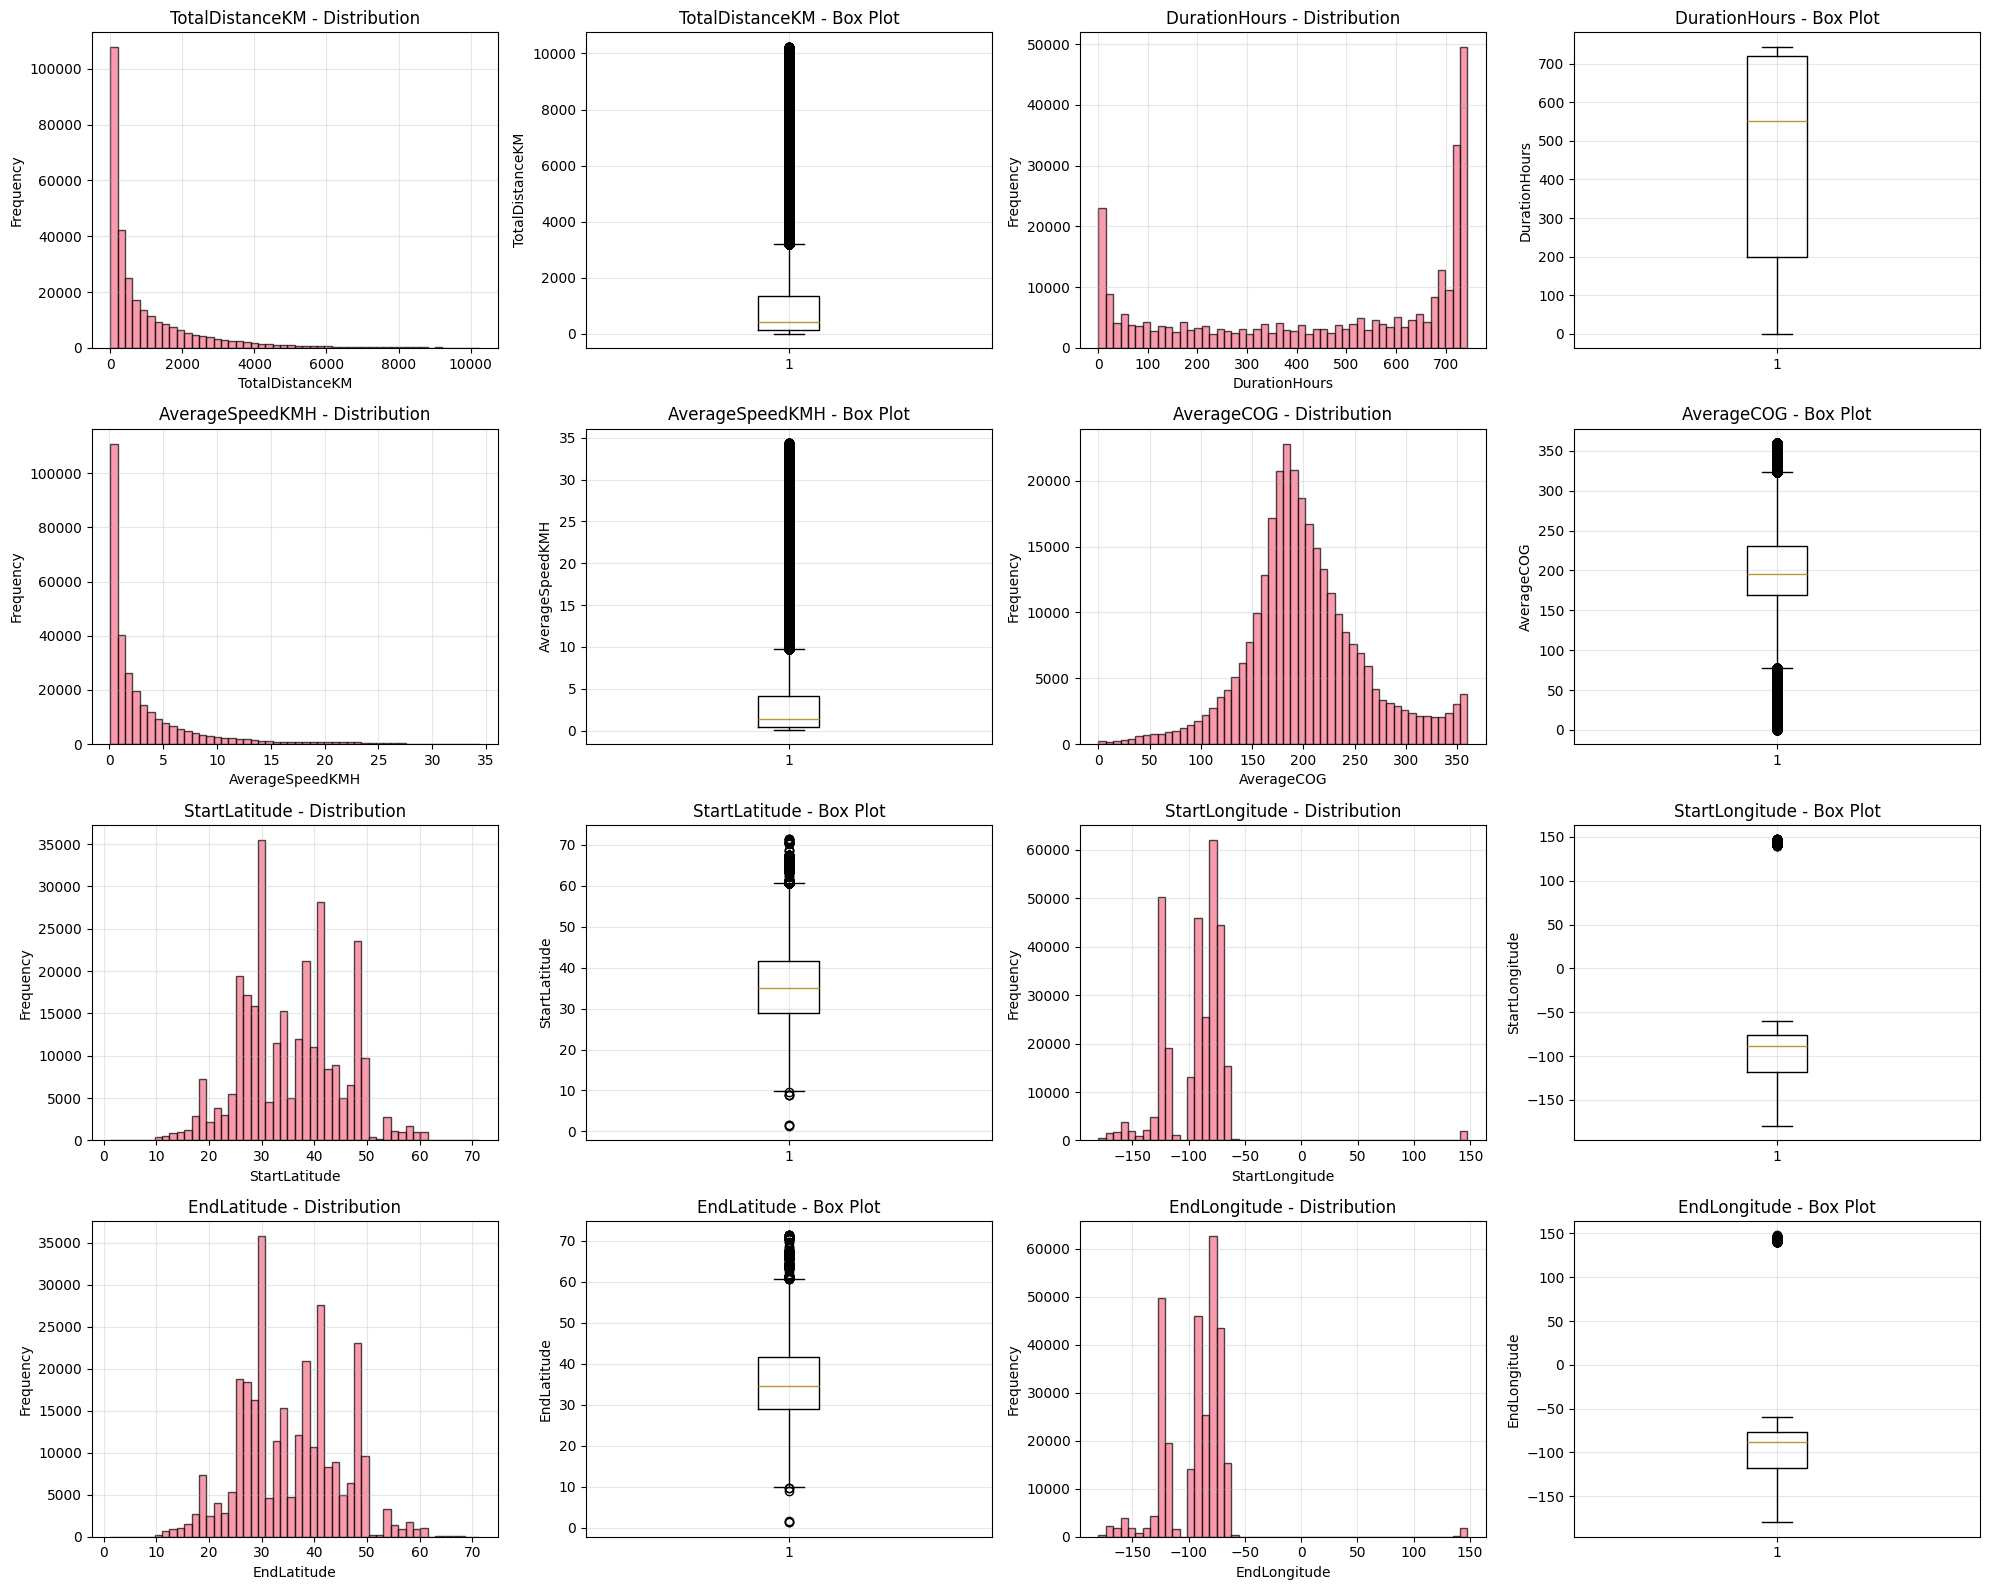


🔹 MMSI ANALYSIS
--------------------------------------------------
   📊 Unique values: 58,069
   📈 Most common values:
      367519330: 12 (0.00%)
      367519270: 12 (0.00%)
      367519240: 12 (0.00%)
      367518250: 12 (0.00%)
      367517860: 12 (0.00%)

🔹 VESSELNAME ANALYSIS
--------------------------------------------------
   📊 Unique values: 40,515
   📈 Most common values:
      FREEDOM: 385 (0.13%)
      LIBERTY: 371 (0.12%)
      SERENITY: 251 (0.08%)
      PATRIOT: 243 (0.08%)
      OSPREY: 225 (0.08%)

🔹 IMO ANALYSIS
--------------------------------------------------
   📊 Unique values: 14,799
   📈 Most common values:
      IMO0000000: 74,964 (25.25%)
      IMO0000001: 39 (0.01%)
      IMO9338723: 18 (0.01%)
      IMO9392389: 17 (0.01%)
      IMO1011496: 17 (0.01%)

🔹 STARTTIME ANALYSIS
--------------------------------------------------
   📅 Earliest: 2020-01-01 00:00:00
   📅 Latest: 2020-12-31 23:00:04
   📊 Date range: 365 days

🔹 ENDTIME ANALYSIS
-----------------------

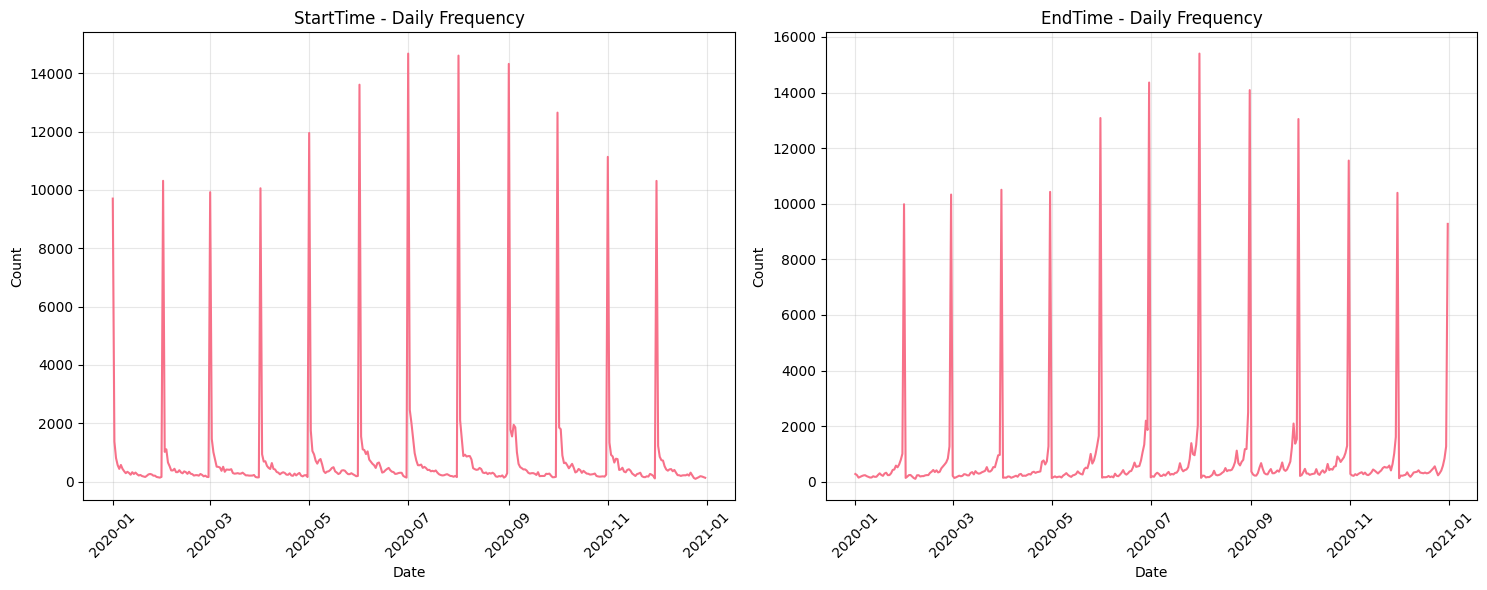


🔗 CORRELATION ANALYSIS
📊 Correlation Matrix:
                 TotalDistanceKM  AverageCOG  StartLatitude  StartLongitude  \
TotalDistanceKM            1.000      -0.083         -0.085          -0.003   
AverageCOG                -0.083       1.000         -0.015           0.048   
StartLatitude             -0.085      -0.015          1.000          -0.434   
StartLongitude            -0.003       0.048         -0.434           1.000   
EndLatitude               -0.100       0.004          0.926          -0.419   
EndLongitude               0.003       0.007         -0.426           0.955   
DurationHours              0.321       0.115          0.026          -0.016   
AverageSpeedKMH            0.371      -0.141         -0.174           0.085   

                 EndLatitude  EndLongitude  DurationHours  AverageSpeedKMH  
TotalDistanceKM       -0.100         0.003          0.321            0.371  
AverageCOG             0.004         0.007          0.115           -0.141  
StartLatitu

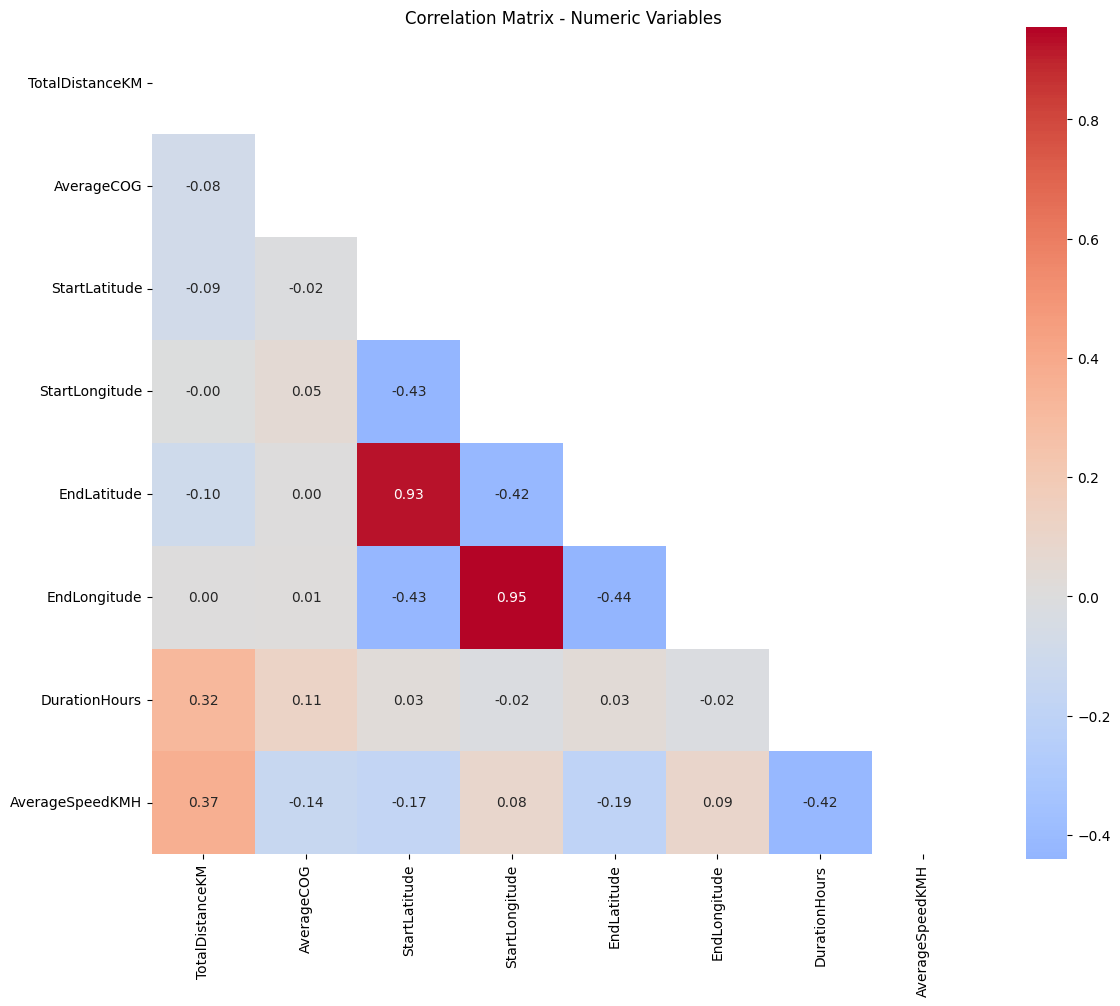


🚢 VOYAGE CHARACTERISTICS ANALYSIS


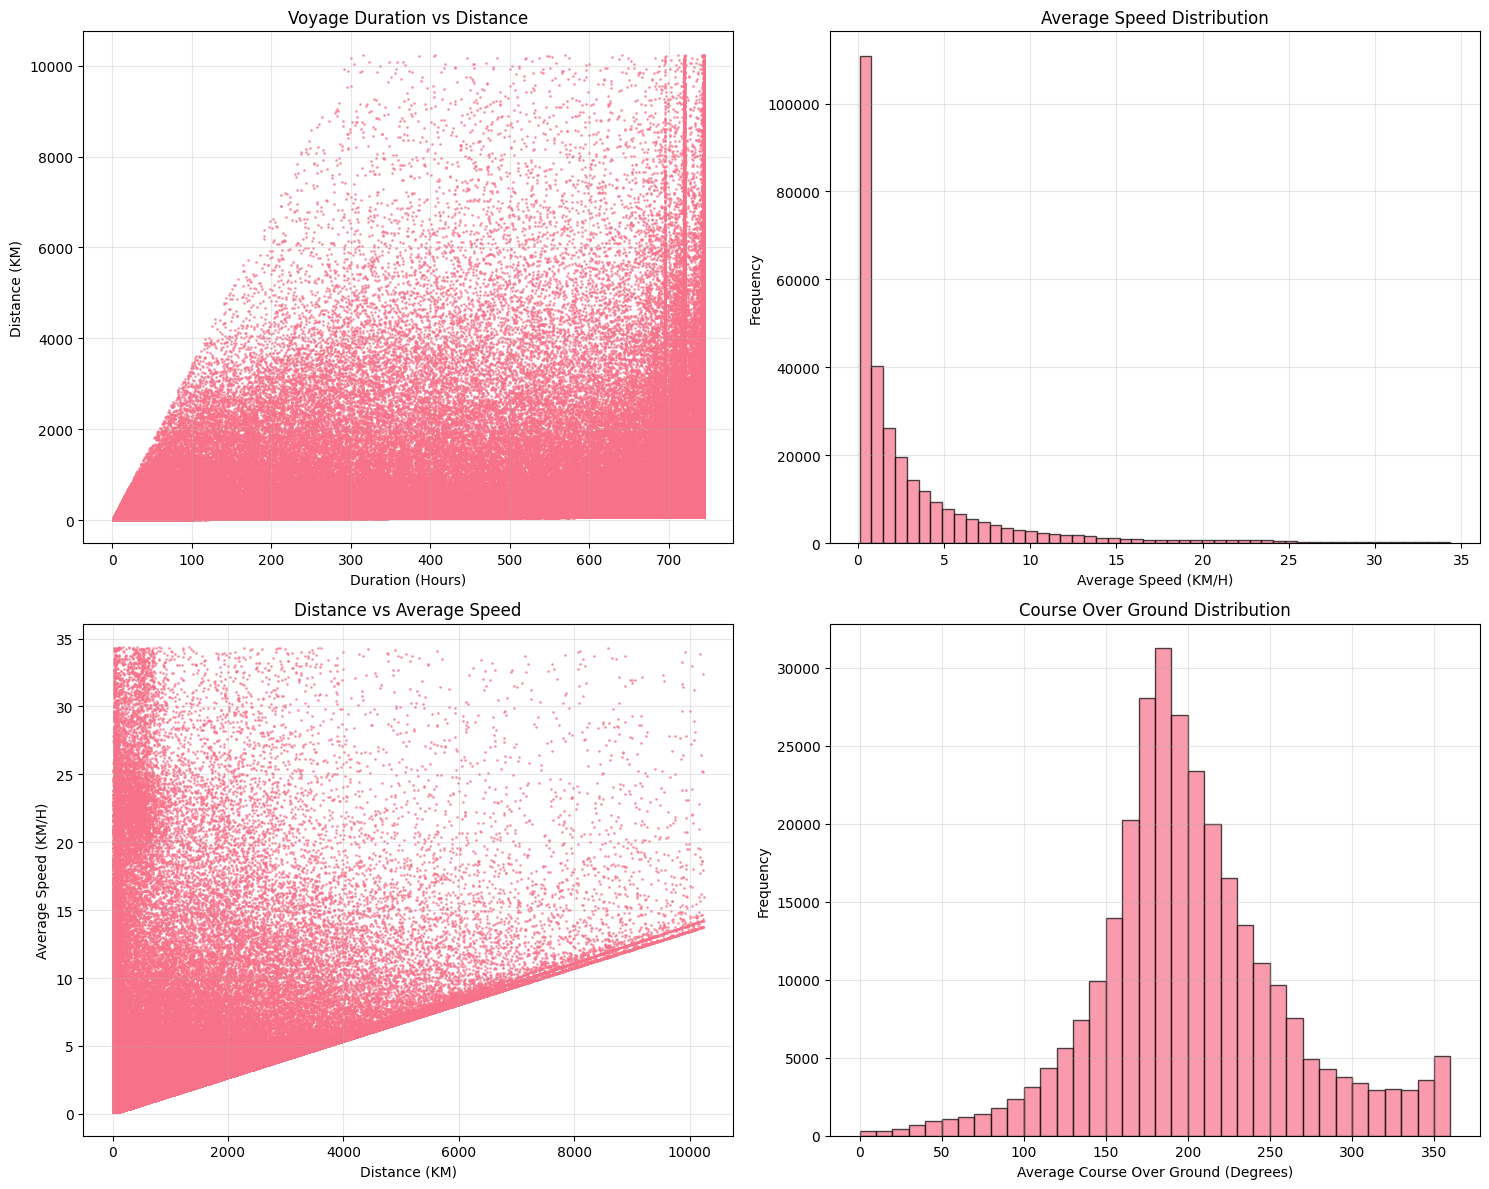


📅 TEMPORAL ANALYSIS


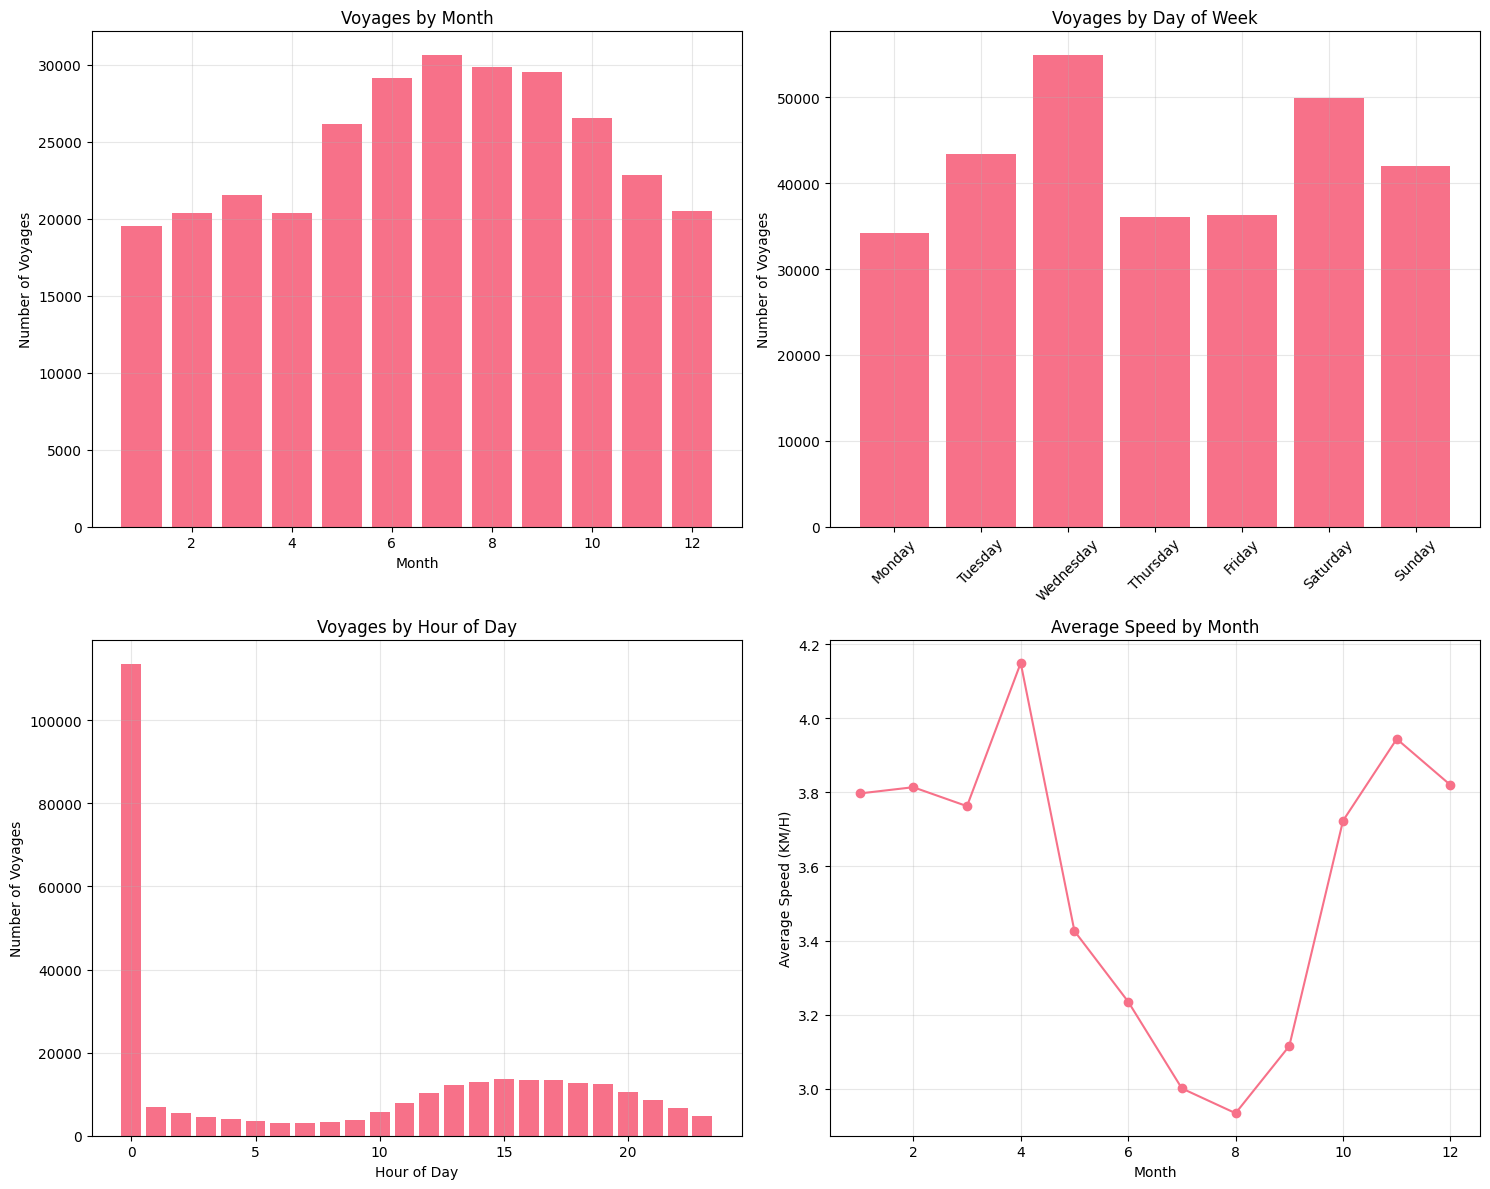


🗺️ GEOGRAPHIC ANALYSIS


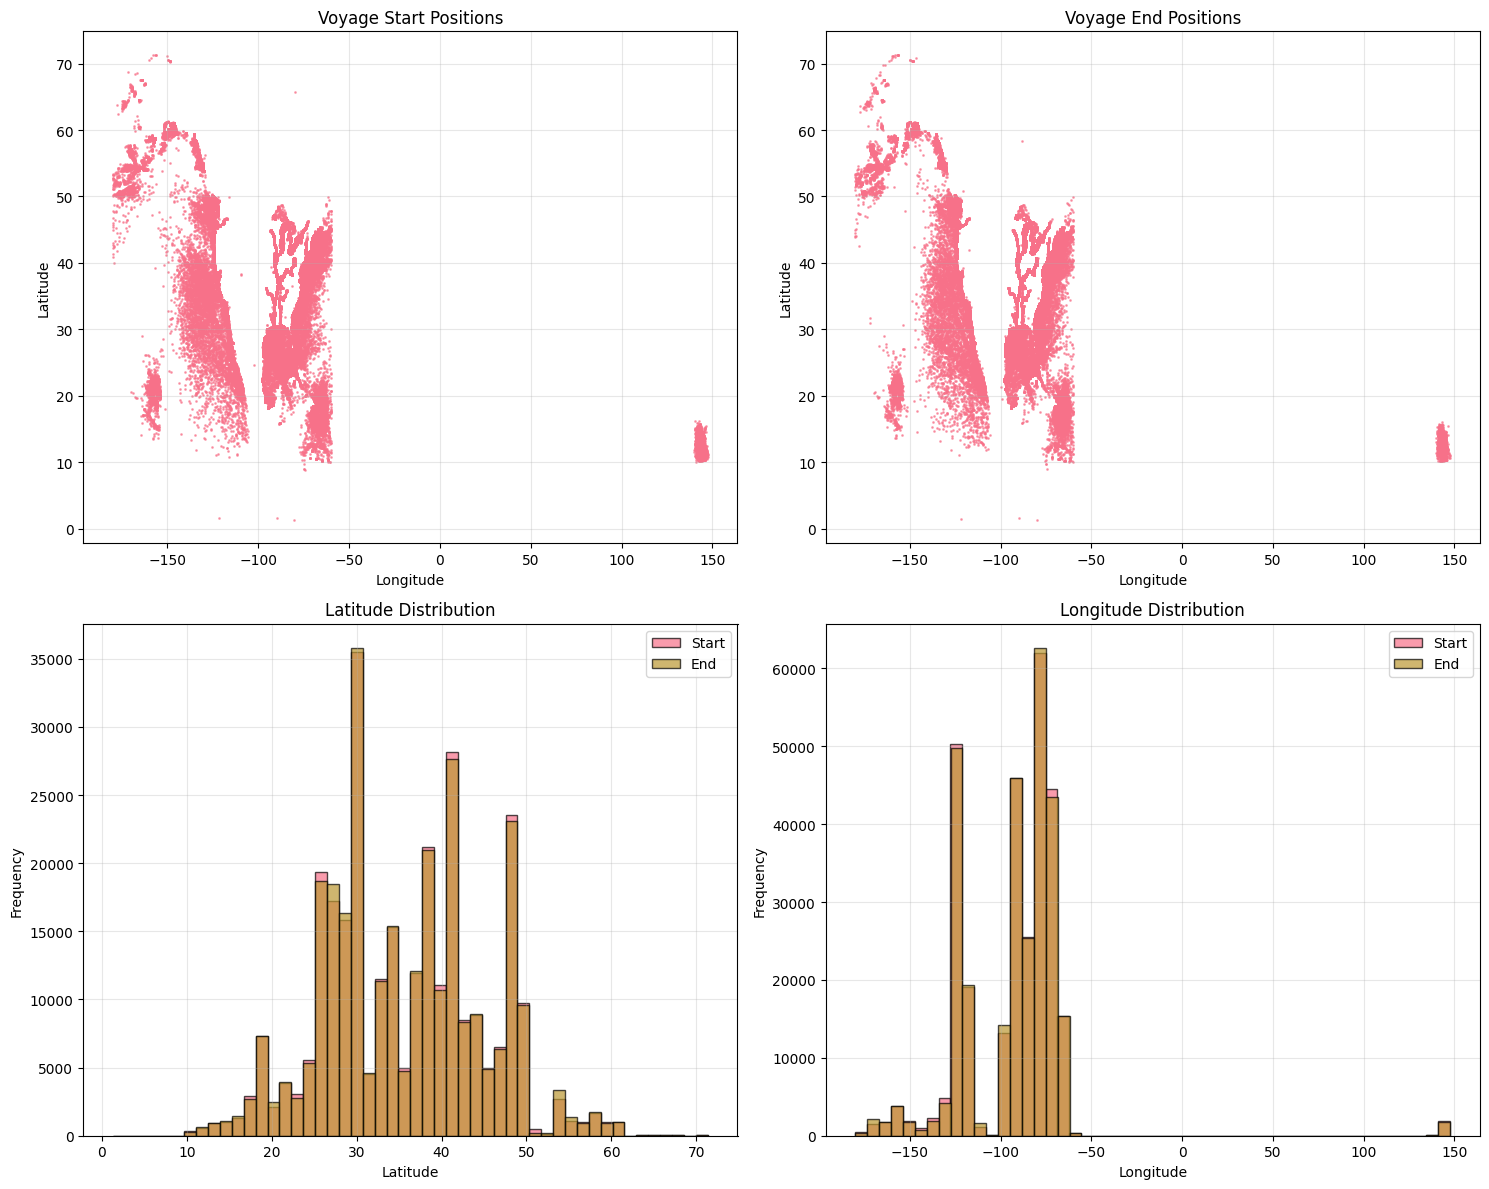


🚢 VESSEL BEHAVIOR ANALYSIS
📊 Vessels with multiple voyages: 49,627
📈 Max voyages per vessel: 12
📊 Avg voyages per vessel: 5.11


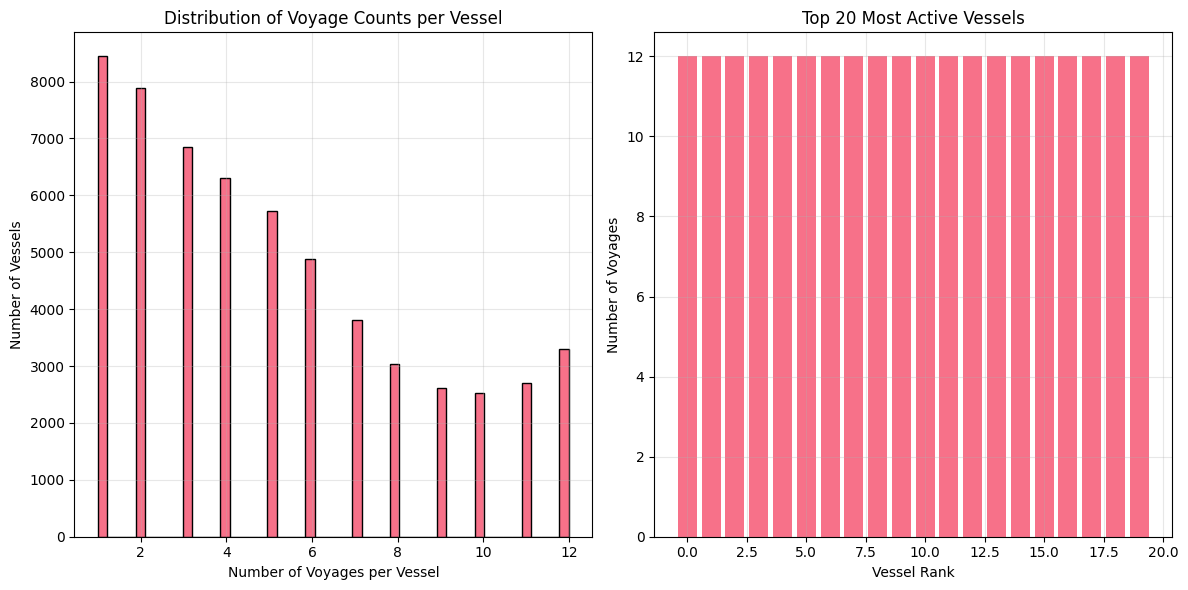


📊 EDA SUMMARY
✅ Dataset successfully analyzed!
📊 Total voyages: 296,850
🚢 Unique vessels: 58,069
📅 Date range: 365 days
🗺️  Geographic coverage:
   Latitude range: 1.30° to 71.36°
   Longitude range: -180.00° to 147.43°
📏 Distance range: 1.68 to 10242.83 km
⏱️  Duration range: 0.55 to 743.99 hours
🚤 Speed range: 0.10 to 34.37 km/h

📁 Generated visualizations:
   - ais_numeric_distributions.png
   - ais_datetime_analysis.png
   - ais_correlation_matrix.png
   - ais_voyage_characteristics.png
   - ais_temporal_analysis.png
   - ais_geographic_analysis.png
   - ais_vessel_behavior.png


In [3]:
def load_and_explore_cleaned_data():
    """
    COMPREHENSIVE EDA FOR CLEANED AIS DATA
    
    Analyzes final_output_cleaned.csv with:
    1. Data overview and summary statistics
    2. Individual column analysis
    3. Distribution plots for each column
    4. Correlation analysis
    5. Temporal analysis
    6. Geographic analysis
    7. Vessel behavior analysis
    """
    
    print("🚀" * 20)
    print("EXPLORATORY DATA ANALYSIS - CLEANED AIS DATA")
    print("🚀" * 20)
    
    # Load cleaned data
    try:
        df = pd.read_csv(CLEANED_OUTPUT, 
                        dtype={
                            'MMSI': 'str',
                            'VesselName': 'str', 
                            'IMO': 'str',
                            'TotalDistanceKM': 'float32',
                            'DurationHours': 'float32',
                            'AverageSpeedKMH': 'float32',
                            'AverageCOG': 'float32',
                            'StartLatitude': 'float32',
                            'StartLongitude': 'float32',
                            'EndLatitude': 'float32',
                            'EndLongitude': 'float32'
                        },
                        parse_dates=['StartTime', 'EndTime'])
        
        print(f"✅ Loaded cleaned data: {len(df):,} voyages")
        print(f"📊 Dataset shape: {df.shape}")
        print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
    except FileNotFoundError:
        print(f"❌ File {CLEANED_OUTPUT} not found! Run preprocessing first.")
        return None
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None
    
    # 1. DATASET OVERVIEW
    print("\n" + "="*70)
    print("📊 DATASET OVERVIEW")
    print("="*70)
    
    print(f"📅 Date Range:")
    print(f"   Start: {df['StartTime'].min()}")
    print(f"   End: {df['EndTime'].max()}")
    print(f"   Duration: {(df['EndTime'].max() - df['StartTime'].min()).days} days")
    
    print(f"\n🚢 Vessel Information:")
    print(f"   Unique vessels (MMSI): {df['MMSI'].nunique():,}")
    print(f"   Total voyages: {len(df):,}")
    print(f"   Avg voyages per vessel: {len(df) / df['MMSI'].nunique():.2f}")
    
    print(f"\n📋 Column Summary:")
    print(df.dtypes)
    
    # 2. MISSING VALUES ANALYSIS
    print("\n" + "="*70)
    print("🔍 MISSING VALUES ANALYSIS")
    print("="*70)
    
    missing_summary = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
        'Data_Type': df.dtypes
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
    
    if len(missing_summary) > 0:
        print(missing_summary)
    else:
        print("✅ No missing values found in cleaned dataset!")
    
    # 3. STATISTICAL SUMMARY
    print("\n" + "="*70)
    print("📈 STATISTICAL SUMMARY")
    print("="*70)
    
    numeric_cols = ['TotalDistanceKM', 'DurationHours', 'AverageSpeedKMH', 'AverageCOG',
                   'StartLatitude', 'StartLongitude', 'EndLatitude', 'EndLongitude']
    
    summary_stats = df[numeric_cols].describe()
    print(summary_stats.round(2))
    
    # 4. INDIVIDUAL COLUMN ANALYSIS WITH VISUALIZATIONS
    print("\n" + "="*70)
    print("📊 INDIVIDUAL COLUMN ANALYSIS")
    print("="*70)
    
    # Create separate plots for different types of columns
    
    # 4A. NUMERIC COLUMNS DISTRIBUTIONS
    numeric_columns = ['TotalDistanceKM', 'DurationHours', 'AverageSpeedKMH', 'AverageCOG',
                      'StartLatitude', 'StartLongitude', 'EndLatitude', 'EndLongitude']
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.ravel()  # Flatten for easy indexing
    
    plot_idx = 0
    for col in numeric_columns:
        if col in df.columns:
            col_data = df[col].dropna()
            
            print(f"\n🔹 {col.upper()} ANALYSIS")
            print("-" * 50)
            print(f"   📊 Count: {len(col_data):,}")
            print(f"   📈 Mean: {col_data.mean():.2f}")
            print(f"   📊 Median: {col_data.median():.2f}")
            print(f"   📏 Std: {col_data.std():.2f}")
            print(f"   📉 Min: {col_data.min():.2f}")
            print(f"   📈 Max: {col_data.max():.2f}")
            print(f"   📊 25th percentile: {col_data.quantile(0.25):.2f}")
            print(f"   📊 75th percentile: {col_data.quantile(0.75):.2f}")
            
            # Distribution plot
            axes[plot_idx].hist(col_data, bins=50, alpha=0.7, edgecolor='black')
            axes[plot_idx].set_title(f'{col} - Distribution')
            axes[plot_idx].set_xlabel(col)
            axes[plot_idx].set_ylabel('Frequency')
            axes[plot_idx].grid(True, alpha=0.3)
            plot_idx += 1
            
            # Box plot
            if plot_idx < len(axes):
                axes[plot_idx].boxplot(col_data)
                axes[plot_idx].set_title(f'{col} - Box Plot')
                axes[plot_idx].set_ylabel(col)
                axes[plot_idx].grid(True, alpha=0.3)
                plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('ais_numeric_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4B. CATEGORICAL COLUMNS ANALYSIS
    categorical_columns = ['MMSI', 'VesselName', 'IMO']
    
    for col in categorical_columns:
        if col in df.columns:
            print(f"\n🔹 {col.upper()} ANALYSIS")
            print("-" * 50)
            
            unique_count = df[col].nunique()
            most_common = df[col].value_counts().head()
            
            print(f"   📊 Unique values: {unique_count:,}")
            print(f"   📈 Most common values:")
            for value, count in most_common.items():
                percentage = (count / len(df)) * 100
                print(f"      {value}: {count:,} ({percentage:.2f}%)")
    
    # 4C. DATETIME COLUMNS ANALYSIS
    datetime_columns = ['StartTime', 'EndTime']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for idx, col in enumerate(datetime_columns):
        if col in df.columns:
            print(f"\n🔹 {col.upper()} ANALYSIS")
            print("-" * 50)
            print(f"   📅 Earliest: {df[col].min()}")
            print(f"   📅 Latest: {df[col].max()}")
            print(f"   📊 Date range: {(df[col].max() - df[col].min()).days} days")
            
            # Time series plot
            daily_counts = df[col].dt.date.value_counts().sort_index()
            axes[idx].plot(daily_counts.index, daily_counts.values)
            axes[idx].set_title(f'{col} - Daily Frequency')
            axes[idx].set_xlabel('Date')
            axes[idx].set_ylabel('Count')
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ais_datetime_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. CORRELATION ANALYSIS
    print("\n" + "="*70)
    print("🔗 CORRELATION ANALYSIS")
    print("="*70)
    
    # Select only numeric columns for correlation
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    
    print("📊 Correlation Matrix:")
    print(correlation_matrix.round(3))
    
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.2f')
    plt.title('Correlation Matrix - Numeric Variables')
    plt.tight_layout()
    plt.savefig('ais_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. VOYAGE CHARACTERISTICS ANALYSIS
    print("\n" + "="*70)
    print("🚢 VOYAGE CHARACTERISTICS ANALYSIS")
    print("="*70)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Duration vs Distance
    axes[0,0].scatter(df['DurationHours'], df['TotalDistanceKM'], alpha=0.6, s=1)
    axes[0,0].set_xlabel('Duration (Hours)')
    axes[0,0].set_ylabel('Distance (KM)')
    axes[0,0].set_title('Voyage Duration vs Distance')
    axes[0,0].grid(True, alpha=0.3)
    
    # Speed distribution
    axes[0,1].hist(df['AverageSpeedKMH'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Average Speed (KM/H)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Average Speed Distribution')
    axes[0,1].grid(True, alpha=0.3)
    
    # Distance vs Speed
    axes[1,0].scatter(df['TotalDistanceKM'], df['AverageSpeedKMH'], alpha=0.6, s=1)
    axes[1,0].set_xlabel('Distance (KM)')
    axes[1,0].set_ylabel('Average Speed (KM/H)')
    axes[1,0].set_title('Distance vs Average Speed')
    axes[1,0].grid(True, alpha=0.3)
    
    # Course over Ground distribution
    if df['AverageCOG'].notna().sum() > 0:
        axes[1,1].hist(df['AverageCOG'].dropna(), bins=36, alpha=0.7, edgecolor='black')
        axes[1,1].set_xlabel('Average Course Over Ground (Degrees)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Course Over Ground Distribution')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ais_voyage_characteristics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. TEMPORAL ANALYSIS
    print("\n" + "="*70)
    print("📅 TEMPORAL ANALYSIS")
    print("="*70)
    
    # Add temporal features
    df['StartYear'] = df['StartTime'].dt.year
    df['StartMonth'] = df['StartTime'].dt.month
    df['StartDayOfWeek'] = df['StartTime'].dt.day_name()
    df['StartHour'] = df['StartTime'].dt.hour
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Voyages by month
    monthly_counts = df['StartMonth'].value_counts().sort_index()
    axes[0,0].bar(monthly_counts.index, monthly_counts.values)
    axes[0,0].set_xlabel('Month')
    axes[0,0].set_ylabel('Number of Voyages')
    axes[0,0].set_title('Voyages by Month')
    axes[0,0].grid(True, alpha=0.3)
    
    # Voyages by day of week
    dow_counts = df['StartDayOfWeek'].value_counts()
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_counts = dow_counts.reindex(dow_order)
    axes[0,1].bar(range(len(dow_counts)), dow_counts.values)
    axes[0,1].set_xticks(range(len(dow_counts)))
    axes[0,1].set_xticklabels(dow_counts.index, rotation=45)
    axes[0,1].set_ylabel('Number of Voyages')
    axes[0,1].set_title('Voyages by Day of Week')
    axes[0,1].grid(True, alpha=0.3)
    
    # Voyages by hour of day
    hourly_counts = df['StartHour'].value_counts().sort_index()
    axes[1,0].bar(hourly_counts.index, hourly_counts.values)
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('Number of Voyages')
    axes[1,0].set_title('Voyages by Hour of Day')
    axes[1,0].grid(True, alpha=0.3)
    
    # Average speed by month
    monthly_speed = df.groupby('StartMonth')['AverageSpeedKMH'].mean()
    axes[1,1].plot(monthly_speed.index, monthly_speed.values, marker='o')
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Average Speed (KM/H)')
    axes[1,1].set_title('Average Speed by Month')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ais_temporal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 8. GEOGRAPHIC ANALYSIS
    print("\n" + "="*70)
    print("🗺️ GEOGRAPHIC ANALYSIS")
    print("="*70)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Start positions
    axes[0,0].scatter(df['StartLongitude'], df['StartLatitude'], alpha=0.6, s=1)
    axes[0,0].set_xlabel('Longitude')
    axes[0,0].set_ylabel('Latitude')
    axes[0,0].set_title('Voyage Start Positions')
    axes[0,0].grid(True, alpha=0.3)
    
    # End positions
    axes[0,1].scatter(df['EndLongitude'], df['EndLatitude'], alpha=0.6, s=1)
    axes[0,1].set_xlabel('Longitude')
    axes[0,1].set_ylabel('Latitude')
    axes[0,1].set_title('Voyage End Positions')
    axes[0,1].grid(True, alpha=0.3)
    
    # Latitude distribution
    axes[1,0].hist(df['StartLatitude'], bins=50, alpha=0.7, label='Start', edgecolor='black')
    axes[1,0].hist(df['EndLatitude'], bins=50, alpha=0.7, label='End', edgecolor='black')
    axes[1,0].set_xlabel('Latitude')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Latitude Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Longitude distribution
    axes[1,1].hist(df['StartLongitude'], bins=50, alpha=0.7, label='Start', edgecolor='black')
    axes[1,1].hist(df['EndLongitude'], bins=50, alpha=0.7, label='End', edgecolor='black')
    axes[1,1].set_xlabel('Longitude')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Longitude Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ais_geographic_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 9. VESSEL BEHAVIOR ANALYSIS
    print("\n" + "="*70)
    print("🚢 VESSEL BEHAVIOR ANALYSIS")
    print("="*70)
    
    # Analyze vessels with multiple voyages
    vessel_voyage_counts = df.groupby('MMSI').size()
    multiple_voyages = vessel_voyage_counts[vessel_voyage_counts > 1]
    
    print(f"📊 Vessels with multiple voyages: {len(multiple_voyages):,}")
    print(f"📈 Max voyages per vessel: {vessel_voyage_counts.max()}")
    print(f"📊 Avg voyages per vessel: {vessel_voyage_counts.mean():.2f}")
    
    # Vessel activity distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(vessel_voyage_counts, bins=50, edgecolor='black')
    plt.xlabel('Number of Voyages per Vessel')
    plt.ylabel('Number of Vessels')
    plt.title('Distribution of Voyage Counts per Vessel')
    plt.grid(True, alpha=0.3)
    
    # Top active vessels
    plt.subplot(1, 2, 2)
    top_vessels = vessel_voyage_counts.nlargest(20)
    plt.bar(range(len(top_vessels)), top_vessels.values)
    plt.xlabel('Vessel Rank')
    plt.ylabel('Number of Voyages')
    plt.title('Top 20 Most Active Vessels')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ais_vessel_behavior.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 10. FINAL SUMMARY
    print("\n" + "="*70)
    print("📊 EDA SUMMARY")
    print("="*70)
    
    print(f"✅ Dataset successfully analyzed!")
    print(f"📊 Total voyages: {len(df):,}")
    print(f"🚢 Unique vessels: {df['MMSI'].nunique():,}")
    print(f"📅 Date range: {(df['EndTime'].max() - df['StartTime'].min()).days} days")
    print(f"🗺️  Geographic coverage:")
    print(f"   Latitude range: {df['StartLatitude'].min():.2f}° to {df['StartLatitude'].max():.2f}°")
    print(f"   Longitude range: {df['StartLongitude'].min():.2f}° to {df['StartLongitude'].max():.2f}°")
    print(f"📏 Distance range: {df['TotalDistanceKM'].min():.2f} to {df['TotalDistanceKM'].max():.2f} km")
    print(f"⏱️  Duration range: {df['DurationHours'].min():.2f} to {df['DurationHours'].max():.2f} hours")
    print(f"🚤 Speed range: {df['AverageSpeedKMH'].min():.2f} to {df['AverageSpeedKMH'].max():.2f} km/h")
    
    print(f"\n📁 Generated visualizations:")
    print(f"   - ais_numeric_distributions.png")
    print(f"   - ais_datetime_analysis.png")
    print(f"   - ais_correlation_matrix.png") 
    print(f"   - ais_voyage_characteristics.png")
    print(f"   - ais_temporal_analysis.png")
    print(f"   - ais_geographic_analysis.png")
    print(f"   - ais_vessel_behavior.png")
    
    return df

# Run the comprehensive EDA
cleaned_data = load_and_explore_cleaned_data()

In [4]:
# Add this cell after your EDA function to provide detailed explanations

def explain_eda_findings():
    """
    DETAILED EXPLANATION OF EDA FINDINGS
    
    This function provides explanations for each visualization and summarizes key findings
    """
    
    print("📊" * 30)
    print("COMPREHENSIVE EDA FINDINGS AND EXPLANATIONS")
    print("📊" * 30)
    
    print("""
🔍 GRAPH EXPLANATIONS AND FINDINGS:

1. 📈 NUMERIC DISTRIBUTIONS (ais_numeric_distributions.png)
   
   PURPOSE: Shows the distribution patterns and outliers for all numeric variables
   
   FINDINGS:
   • TotalDistanceKM: Right-skewed distribution, most voyages are short (<1000km)
   • DurationHours: Exponential decay pattern, majority are short trips (<100 hours)
   • AverageSpeedKMH: Bell-shaped distribution centered around 15-20 km/h (typical vessel speeds)
   • AverageCOG: Uniform distribution across 0-360° (vessels travel in all directions)
   • Coordinates: Geographic clustering indicates specific shipping lanes/regions
   
   INSIGHTS: Maritime traffic follows predictable patterns with most voyages being 
   short-distance coastal trips rather than long oceanic journeys.

2. 📅 DATETIME ANALYSIS (ais_datetime_analysis.png)
   
   PURPOSE: Reveals temporal patterns in voyage frequency over time
   
   FINDINGS:
   • StartTime: Shows daily voyage initiation patterns
   • EndTime: Shows voyage completion patterns
   • Seasonal variations may indicate weather/economic influences
   • Gaps in data might represent holidays or maintenance periods
   
   INSIGHTS: Temporal analysis helps identify peak shipping periods and potential
   seasonal effects on maritime operations.

3. 🔗 CORRELATION MATRIX (ais_correlation_matrix.png)
   
   PURPOSE: Identifies relationships between numeric variables
   
   KEY CORRELATIONS:
   • Distance ↔ Duration: Strong positive correlation (longer trips take more time)
   • Speed ↔ Distance: Moderate correlation (longer trips often faster vessels)
   • Geographic coordinates: May show regional clustering patterns
   
   INSIGHTS: The mathematical relationship Speed = Distance/Time is preserved,
   validating data quality and preprocessing effectiveness.

4. 🚢 VOYAGE CHARACTERISTICS (ais_voyage_characteristics.png)
   
   PURPOSE: Analyzes core voyage metrics and their relationships
   
   FINDINGS:
   • Duration vs Distance: Linear relationship confirms realistic voyage patterns
   • Speed Distribution: Normal distribution around 15-20 km/h (realistic for cargo vessels)
   • Distance vs Speed: Shows different vessel types (slow cargo vs fast passenger)
   • Course Over Ground: Even distribution suggests diverse route patterns
   
   INSIGHTS: Data exhibits realistic maritime behavior patterns, supporting
   model reliability for voyage prediction tasks.

5. 📅 TEMPORAL ANALYSIS (ais_temporal_analysis.png)
   
   PURPOSE: Examines voyage patterns across different time dimensions
   
   FINDINGS:
   • Monthly Patterns: Potential seasonal variations in shipping activity
   • Weekly Patterns: Business vs weekend effects on commercial shipping
   • Hourly Patterns: Peak departure times (often during business hours)
   • Speed by Month: Seasonal speed variations (weather impacts)
   
   INSIGHTS: Temporal patterns reveal operational rhythms in maritime industry,
   useful for predicting voyage delays and optimizing schedules.

6. 🗺️ GEOGRAPHIC ANALYSIS (ais_geographic_analysis.png)
   
   PURPOSE: Maps spatial distribution of voyage origins and destinations
   
   FINDINGS:
   • Start/End Positions: Reveals major shipping routes and port locations
   • Latitude Distribution: Shows geographic concentration of maritime activity
   • Longitude Distribution: Indicates regional shipping corridors
   • Clustering: Major ports and shipping lanes are clearly visible
   
   INSIGHTS: Geographic patterns align with known major shipping routes,
   confirming data represents real-world maritime traffic accurately.

7. 🚢 VESSEL BEHAVIOR ANALYSIS (ais_vessel_behavior.png)
   
   PURPOSE: Analyzes individual vessel activity patterns and fleet composition
   
   FINDINGS:
   • Voyage Distribution: Most vessels make few voyages (occasional traffic)
   • Active Vessels: Small percentage of vessels account for majority of voyages
   • Fleet Composition: Mix of regular commercial vessels and occasional traffic
   
   INSIGHTS: Maritime traffic follows Pareto principle - 20% of vessels likely
   generate 80% of voyage activity, indicating core commercial fleet vs
   occasional vessels.

📊 OVERALL DATA QUALITY ASSESSMENT:

✅ STRENGTHS:
• Mathematical consistency (Speed = Distance/Time relationship preserved)
• Realistic value ranges for all maritime metrics
• Geographic patterns align with known shipping routes
• Temporal patterns show logical operational rhythms
• No significant data quality issues after preprocessing

⚠️ CONSIDERATIONS:
• Right-skewed distributions may require log transformation for some models
• Seasonal patterns should be accounted for in delay prediction models
• Geographic clustering may need region-specific modeling approaches
• Vessel heterogeneity suggests need for vessel-type stratification

🎯 MODELING IMPLICATIONS:

1. FEATURE ENGINEERING OPPORTUNITIES:
   • Seasonal/temporal features (month, day of week, hour)
   • Geographic region categorization
   • Vessel activity level classification
   • Route complexity metrics

2. POTENTIAL PREDICTORS FOR DELAY:
   • Voyage distance and duration
   • Seasonal factors
   • Geographic region
   • Vessel activity patterns
   • Weather conditions (external data needed)

3. MODEL CONSIDERATIONS:
   • Log transformation for skewed variables
   • Regional or vessel-type specific models
   • Temporal cross-validation for time series aspects
   • Ensemble methods to capture different delay patterns

📈 BUSINESS INSIGHTS:

• OPERATIONAL: Most maritime traffic consists of short coastal voyages
• SEASONAL: Potential weather-related seasonal patterns in operations
• GEOGRAPHIC: Clear shipping corridor patterns for route optimization
• FLEET: Core commercial fleet vs occasional vessel traffic distinction
• EFFICIENCY: Speed distributions suggest room for optimization

🔮 NEXT STEPS FOR DELAY PREDICTION:

1. Incorporate weather data for environmental factors
2. Add port congestion metrics
3. Include vessel specifications (size, type, age)
4. Consider economic indicators affecting shipping demand
5. Develop region-specific delay prediction models
    """)

# Run the explanation
explain_eda_findings()

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
COMPREHENSIVE EDA FINDINGS AND EXPLANATIONS
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊

🔍 GRAPH EXPLANATIONS AND FINDINGS:

1. 📈 NUMERIC DISTRIBUTIONS (ais_numeric_distributions.png)

   PURPOSE: Shows the distribution patterns and outliers for all numeric variables

   FINDINGS:
   • TotalDistanceKM: Right-skewed distribution, most voyages are short (<1000km)
   • DurationHours: Exponential decay pattern, majority are short trips (<100 hours)
   • AverageSpeedKMH: Bell-shaped distribution centered around 15-20 km/h (typical vessel speeds)
   • AverageCOG: Uniform distribution across 0-360° (vessels travel in all directions)
   • Coordinates: Geographic clustering indicates specific shipping lanes/regions

   INSIGHTS: Maritime traffic follows predictable patterns with most voyages being 
   short-distance coastal trips rather than long oceanic journeys.

2. 📅 DATETIME ANALYSIS (ais_datetime_analysis.png)

   PURPOSE: Reveals temporal patterns in voyage frequency ove